# Step 1.2: Text Preprocessing
## LinkedIn Engagement Prediction - TrendPilot

**Date:** February 1, 2026  
**Objective:** Clean and normalize post content text for NLP feature extraction

---

## Overview

This notebook performs comprehensive text preprocessing on LinkedIn post content. We will:
1. Extract structural elements (URLs, mentions, hashtags, emojis)
2. Create clean text for NLP analysis
3. Preserve original features for base formula calculations
4. Generate preprocessing statistics

**Why Text Preprocessing Matters:**
- URLs and mentions don't add semantic value but affect engagement (link penalty)
- Emojis convey emotion and should be quantified separately
- Clean text improves NLP model performance (sentiment, NER, embeddings)
- Hashtags need special handling (they're both content and metadata)

---

## 1. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import re
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set_style('whitegrid')

print("✓ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Libraries imported successfully
Pandas version: 3.0.0
NumPy version: 2.3.5


## 2. Load Cleaned Data

We'll load the cleaned dataset from Step 1.1.

In [2]:
# Define file paths
INPUT_FILE = '../data/cleaned_data.csv'
OUTPUT_FILE = '../data/preprocessed_data.csv'
STATS_FILE = '../data/preprocessing_stats.json'

# Load data
df = pd.read_csv(INPUT_FILE)

print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")
df.head(3)

Dataset loaded: 772 rows × 19 columns

Columns: ['name', 'headline', 'location', 'followers', 'connections', 'about', 'time_spent', 'content', 'content_links', 'media_type', 'media_url', 'num_hashtags', 'hashtag_followers', 'hashtags', 'reactions', 'comments', 'views', 'votes', 'content_length']


,name,headline,location,followers,connections,about,time_spent,content,content_links,media_type,media_url,num_hashtags,hashtag_followers,hashtags,reactions,comments,views,votes,content_length
0,kevinswiber,I’m not famous.,NaN,3690,500,NaN,5,"I’m not famous. I’m not even popular. But I have mentored people from hobbyists to founders, fro...",NaN,post,NaN,0,NaN,NaN,65.0,8.0,NaN,NaN,189
1,puneet-bhardwaj-849aa01,AI at the speed of light!,NaN,2546,500,NaN,3,AI at the speed of light! While researching the most recent advances in edge computing I came ac...,https://lnkd.in/g8eTMBQu; https://www.linkedin.com/feed/hashtag/edgecomputing; https://www.linke...,post,NaN,4,NaN,#EdgeComputing; #MIT; #Innovation; #FutureOfTech,34.0,2.0,NaN,NaN,1519
2,jainnitin1983,I wanted to share that I’ve decided to move on from Kinetix.,NaN,3888,500,NaN,1,I wanted to share that I’ve decided to move on from Kinetix . It’s been an incredibly rewarding ...,https://www.linkedin.com/company/kinetix-trading-solutions?trk=public_post-text; https://www.lin...,post,NaN,0,NaN,NaN,34.0,5.0,NaN,NaN,452


## 3. Initial Content Analysis

Before preprocessing, let's understand what patterns exist in the raw content.

In [3]:
# Sample posts to understand content patterns
print("Sample post 1 (first 500 chars):")
print("="*80)
print(df['content'].iloc[0][:500])
print("\n" + "="*80)

print("\nSample post 2 (first 500 chars):")
print("="*80)
print(df['content'].iloc[10][:500])
print("\n" + "="*80)

Sample post 1 (first 500 chars):
I’m not famous. I’m not even popular. But I have mentored people from hobbyists to founders, from kids to parents, from lost to determined. At the end of the day, that’s good enough for me.


Sample post 2 (first 500 chars):
If you’re working on AI beyond toy demos, this is worth a look. Most teams aren’t blocked by prompts anymore. They’re blocked by integrations that fall apart in production, auth, boundaries, observability, and “how do we standardise this across teams?”. Packt is hosting a live 4-hour MCP masterclass on using Model Context Protocol (MCP) as a standard, governed integration layer, instead of wiring yet another one-off “tools API”. The workshop will cover: ↪️ The MCP model in practice (Host / Clien



## 4. URL Extraction

**Why Extract URLs:**
- External links reduce engagement (per base formula - link penalty)
- URLs don't provide semantic meaning for NLP
- Need to count them for base formula feature calculation

**Approach:**
- Use regex to detect http/https URLs
- Extract and count URLs per post
- Replace with placeholder token to preserve sentence structure

In [4]:
# Regex pattern for URLs (matches http/https)
URL_PATTERN = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def extract_urls(text):
    """
    Extract URLs from text and return count and list.
    
    Args:
        text: Input text string
    
    Returns:
        tuple: (url_count, list_of_urls)
    """
    if pd.isna(text):
        return 0, []
    
    urls = re.findall(URL_PATTERN, str(text))
    return len(urls), urls

def remove_urls(text):
    """
    Replace URLs with [URL] token.
    This preserves sentence structure while removing the actual link.
    """
    if pd.isna(text):
        return text
    return re.sub(URL_PATTERN, '[URL]', str(text))

# Extract URL features
print("Extracting URLs...")
df[['url_count', 'urls_list']] = df['content'].apply(
    lambda x: pd.Series(extract_urls(x))
)

# Create has_external_link feature (important for base formula)
df['has_external_link'] = (df['url_count'] > 0).astype(int)

print(f"✓ URL extraction complete")
print(f"  Posts with URLs: {df['has_external_link'].sum():,} ({df['has_external_link'].mean()*100:.1f}%)")
print(f"  Total URLs found: {df['url_count'].sum():,}")
print(f"  Avg URLs per post (when present): {df[df['url_count']>0]['url_count'].mean():.2f}")

Extracting URLs...
✓ URL extraction complete
  Posts with URLs: 211 (27.3%)
  Total URLs found: 446
  Avg URLs per post (when present): 2.11


## 5. Mention Extraction (@username)

**Why Extract Mentions:**
- @mentions tag other users, affecting reach
- They're structural elements, not content
- Counting mentions helps identify collaborative posts

**Pattern:** @username or @FirstName LastName

In [5]:
# Regex for @mentions (LinkedIn format)
MENTION_PATTERN = r'@[A-Za-z0-9_\s]+'

def extract_mentions(text):
    """
    Extract @mentions from text.
    
    Returns:
        tuple: (mention_count, list_of_mentions)
    """
    if pd.isna(text):
        return 0, []
    
    mentions = re.findall(MENTION_PATTERN, str(text))
    # Clean up mentions (remove trailing spaces)
    mentions = [m.strip() for m in mentions]
    return len(mentions), mentions

def remove_mentions(text):
    """
    Replace @mentions with [MENTION] token.
    """
    if pd.isna(text):
        return text
    return re.sub(MENTION_PATTERN, '[MENTION]', str(text))

# Extract mention features
print("Extracting mentions...")
df[['mention_count', 'mentions_list']] = df['content'].apply(
    lambda x: pd.Series(extract_mentions(x))
)

print(f"✓ Mention extraction complete")
print(f"  Posts with mentions: {(df['mention_count']>0).sum():,} ({(df['mention_count']>0).mean()*100:.1f}%)")
print(f"  Total mentions found: {df['mention_count'].sum():,}")
print(f"  Avg mentions per post (when present): {df[df['mention_count']>0]['mention_count'].mean():.2f}")

Extracting mentions...
✓ Mention extraction complete
  Posts with mentions: 34 (4.4%)
  Total mentions found: 65
  Avg mentions per post (when present): 1.91


## 6. Hashtag Extraction

**Why Extract Hashtags:**
- Already have num_hashtags from raw data
- Need to extract actual hashtag text for topic relevance
- Hashtags are metadata, not prose content

**Note:** We'll preserve hashtags in content for now since they carry topical information.

In [6]:
# Regex for hashtags
HASHTAG_PATTERN = r'#[A-Za-z0-9_]+'

def extract_hashtags(text):
    """
    Extract hashtags from text.
    
    Returns:
        tuple: (hashtag_count, list_of_hashtags)
    """
    if pd.isna(text):
        return 0, []
    
    hashtags = re.findall(HASHTAG_PATTERN, str(text))
    return len(hashtags), hashtags

# Extract hashtag features
print("Extracting hashtags...")
df[['hashtag_count_extracted', 'hashtags_list']] = df['content'].apply(
    lambda x: pd.Series(extract_hashtags(x))
)

# Compare with existing num_hashtags column
print(f"✓ Hashtag extraction complete")
print(f"  Posts with hashtags: {(df['hashtag_count_extracted']>0).sum():,} ({(df['hashtag_count_extracted']>0).mean()*100:.1f}%)")
print(f"  Total hashtags found: {df['hashtag_count_extracted'].sum():,}")
print(f"  Avg hashtags per post (when present): {df[df['hashtag_count_extracted']>0]['hashtag_count_extracted'].mean():.2f}")

# Verify against original num_hashtags
mismatch = (df['hashtag_count_extracted'] != df['num_hashtags']).sum()
print(f"\n  Mismatch with num_hashtags column: {mismatch:,} posts")
if mismatch > 0:
    print(f"  (This is normal - num_hashtags may count differently)")

Extracting hashtags...
✓ Hashtag extraction complete
  Posts with hashtags: 281 (36.4%)
  Total hashtags found: 1,567
  Avg hashtags per post (when present): 5.58

  Mismatch with num_hashtags column: 52 posts
  (This is normal - num_hashtags may count differently)


## 7. Emoji Extraction

**Why Extract Emojis:**
- Emojis convey emotion and personality
- They don't work well with traditional NLP tokenizers
- Emoji count is a valuable engagement feature
- Need to quantify emoji usage separately from text

**Approach:**
- Use Unicode ranges to detect emojis
- Count total emojis and unique emoji types
- Remove from clean_content but preserve in original

In [7]:
# Emoji pattern (comprehensive Unicode ranges)
EMOJI_PATTERN = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U00002702-\U000027B0"  # dingbats
    "\U000024C2-\U0001F251"
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U00002600-\U000026FF"  # Miscellaneous Symbols
    "]+", 
    flags=re.UNICODE
)

def extract_emojis(text):
    """
    Extract emojis from text.
    
    Returns:
        tuple: (emoji_count, unique_emoji_count, list_of_emojis)
    """
    if pd.isna(text):
        return 0, 0, []
    
    emojis = EMOJI_PATTERN.findall(str(text))
    # Flatten (some emojis might be multi-character)
    all_emojis = ''.join(emojis)
    unique_emojis = len(set(all_emojis))
    
    return len(all_emojis), unique_emojis, list(all_emojis)

def remove_emojis(text):
    """
    Remove emojis from text.
    """
    if pd.isna(text):
        return text
    return EMOJI_PATTERN.sub('', str(text))

# Extract emoji features
print("Extracting emojis...")
df[['emoji_count', 'unique_emoji_count', 'emojis_list']] = df['content'].apply(
    lambda x: pd.Series(extract_emojis(x))
)

print(f"✓ Emoji extraction complete")
print(f"  Posts with emojis: {(df['emoji_count']>0).sum():,} ({(df['emoji_count']>0).mean()*100:.1f}%)")
print(f"  Total emojis found: {df['emoji_count'].sum():,}")
print(f"  Avg emojis per post (when present): {df[df['emoji_count']>0]['emoji_count'].mean():.2f}")
print(f"  Avg unique emojis per post (when present): {df[df['emoji_count']>0]['unique_emoji_count'].mean():.2f}")

Extracting emojis...
✓ Emoji extraction complete
  Posts with emojis: 298 (38.6%)
  Total emojis found: 6,199
  Avg emojis per post (when present): 20.80
  Avg unique emojis per post (when present): 7.70


## 8. Create Clean Content

**Cleaning Strategy:**

1. **Remove URLs** → [URL] token
2. **Remove @mentions** → [MENTION] token
3. **Remove emojis** → deleted (already counted)
4. **Keep hashtags** → they carry topical meaning
5. **Normalize whitespace** → single spaces
6. **Remove special characters** → keep letters, numbers, basic punctuation
7. **Lowercase** → for NLP consistency

**Why NOT Remove Everything:**
- Hashtags contain topic keywords (#AI, #Leadership)
- Numbers are meaningful ("10 years", "$1M revenue")
- Punctuation helps sentence detection
- [URL] and [MENTION] tokens preserve sentence structure

In [8]:
def create_clean_content(text):
    """
    Comprehensive text cleaning pipeline.
    
    Steps:
    1. Replace URLs with [URL]
    2. Replace mentions with [MENTION]
    3. Remove emojis
    4. Remove extra whitespace
    5. Remove special characters (keep alphanumeric, hashtags, basic punctuation)
    6. Lowercase
    
    Returns:
        Cleaned text string
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Step 1: Replace URLs
    text = remove_urls(text)
    
    # Step 2: Replace mentions
    text = remove_mentions(text)
    
    # Step 3: Remove emojis
    text = remove_emojis(text)
    
    # Step 4: Remove extra whitespace (multiple spaces, newlines, tabs)
    text = re.sub(r'\s+', ' ', text)
    
    # Step 5: Remove special characters
    # Keep: letters, numbers, hashtags, spaces, basic punctuation (.!?,;:)
    text = re.sub(r'[^a-zA-Z0-9#\s.!?,;:\-\'\"]+', '', text)
    
    # Step 6: Lowercase
    text = text.lower()
    
    # Step 7: Strip leading/trailing spaces
    text = text.strip()
    
    return text

# Apply cleaning
print("Creating clean content...")
df['clean_content'] = df['content'].apply(create_clean_content)

# Calculate cleaning effectiveness
avg_original_length = df['content'].str.len().mean()
avg_clean_length = df['clean_content'].str.len().mean()
reduction_pct = (1 - avg_clean_length / avg_original_length) * 100

print(f"✓ Clean content created")
print(f"  Avg original length: {avg_original_length:.1f} characters")
print(f"  Avg clean length: {avg_clean_length:.1f} characters")
print(f"  Reduction: {reduction_pct:.1f}%")

Creating clean content...
✓ Clean content created
  Avg original length: 1967.2 characters
  Avg clean length: 1922.0 characters
  Reduction: 2.3%


## 9. Before/After Examples

Let's examine specific posts to verify our cleaning is working correctly.

In [9]:
# Find posts with URLs, mentions, and emojis for demonstration
rich_posts = df[
    (df['url_count'] > 0) | 
    (df['mention_count'] > 0) | 
    (df['emoji_count'] > 0)
].head(5)

for idx, row in rich_posts.iterrows():
    print("="*80)
    print(f"POST {idx}")
    print(f"URLs: {row['url_count']} | Mentions: {row['mention_count']} | Emojis: {row['emoji_count']}")
    print("-"*80)
    print("ORIGINAL (first 300 chars):")
    print(row['content'][:300])
    print("-"*80)
    print("CLEANED (first 300 chars):")
    print(row['clean_content'][:300])
    print("\n")

POST 1
URLs: 1 | Mentions: 0 | Emojis: 1
--------------------------------------------------------------------------------
ORIGINAL (first 300 chars):
AI at the speed of light! While researching the most recent advances in edge computing I came across a research paper published by MIT news last year in June. We talk a lot about "The Edge," but the physical limits of silicon have always been the bottleneck. That changed in June of 2025. MIT News fe
--------------------------------------------------------------------------------
CLEANED (first 300 chars):
ai at the speed of light! while researching the most recent advances in edge computing i came across a research paper published by mit news last year in june. we talk a lot about "the edge," but the physical limits of silicon have always been the bottleneck. that changed in june of 2025. mit news fe


POST 3
URLs: 0 | Mentions: 0 | Emojis: 1
--------------------------------------------------------------------------------
ORIGINAL (first 

## 10. Text Statistics

Calculate additional text features for analysis and modeling.

In [10]:
# Character counts
df['char_count_original'] = df['content'].str.len()
df['char_count_clean'] = df['clean_content'].str.len()

# Word counts (simple split on whitespace)
df['word_count_original'] = df['content'].str.split().str.len()
df['word_count_clean'] = df['clean_content'].str.split().str.len()

# Sentence counts (rough estimate using .!? as delimiters)
df['sentence_count'] = df['clean_content'].apply(
    lambda x: len(re.split(r'[.!?]+', str(x))) if pd.notna(x) else 0
)

# Punctuation counts
df['question_mark_count'] = df['content'].str.count(r'\?')
df['exclamation_mark_count'] = df['content'].str.count(r'!')

# Line break counts (multiline posts)
df['line_break_count'] = df['content'].str.count(r'\n')

print("✓ Text statistics calculated")
print(f"\nWord count statistics (clean):")
print(df['word_count_clean'].describe())

✓ Text statistics calculated

Word count statistics (clean):
count     772.000000
mean      310.796632
std       360.785943
min         2.000000
25%        88.000000
50%       173.000000
75%       360.750000
max      2132.000000
Name: word_count_clean, dtype: float64


## 11. Preprocessing Summary Statistics

In [11]:
# Create comprehensive statistics
preprocessing_stats = {
    'total_posts': len(df),
    
    'url_stats': {
        'posts_with_urls': int(df['has_external_link'].sum()),
        'pct_with_urls': float(df['has_external_link'].mean() * 100),
        'total_urls': int(df['url_count'].sum()),
        'avg_urls_when_present': float(df[df['url_count']>0]['url_count'].mean()) if df['url_count'].sum() > 0 else 0
    },
    
    'mention_stats': {
        'posts_with_mentions': int((df['mention_count']>0).sum()),
        'pct_with_mentions': float((df['mention_count']>0).mean() * 100),
        'total_mentions': int(df['mention_count'].sum()),
        'avg_mentions_when_present': float(df[df['mention_count']>0]['mention_count'].mean()) if df['mention_count'].sum() > 0 else 0
    },
    
    'emoji_stats': {
        'posts_with_emojis': int((df['emoji_count']>0).sum()),
        'pct_with_emojis': float((df['emoji_count']>0).mean() * 100),
        'total_emojis': int(df['emoji_count'].sum()),
        'avg_emojis_when_present': float(df[df['emoji_count']>0]['emoji_count'].mean()) if df['emoji_count'].sum() > 0 else 0
    },
    
    'hashtag_stats': {
        'posts_with_hashtags': int((df['hashtag_count_extracted']>0).sum()),
        'pct_with_hashtags': float((df['hashtag_count_extracted']>0).mean() * 100),
        'total_hashtags': int(df['hashtag_count_extracted'].sum()),
        'avg_hashtags_when_present': float(df[df['hashtag_count_extracted']>0]['hashtag_count_extracted'].mean()) if df['hashtag_count_extracted'].sum() > 0 else 0
    },
    
    'text_length_stats': {
        'avg_char_original': float(df['char_count_original'].mean()),
        'avg_char_clean': float(df['char_count_clean'].mean()),
        'avg_reduction_pct': float((1 - df['char_count_clean'].mean() / df['char_count_original'].mean()) * 100),
        'avg_word_count_clean': float(df['word_count_clean'].mean()),
        'avg_sentence_count': float(df['sentence_count'].mean())
    }
}

print("Preprocessing Statistics:")
print("="*80)
print(json.dumps(preprocessing_stats, indent=2))

Preprocessing Statistics:
{
  "total_posts": 772,
  "url_stats": {
    "posts_with_urls": 211,
    "pct_with_urls": 27.33160621761658,
    "total_urls": 446,
    "avg_urls_when_present": 2.1137440758293837
  },
  "mention_stats": {
    "posts_with_mentions": 34,
    "pct_with_mentions": 4.404145077720207,
    "total_mentions": 65,
    "avg_mentions_when_present": 1.911764705882353
  },
  "emoji_stats": {
    "posts_with_emojis": 298,
    "pct_with_emojis": 38.60103626943005,
    "total_emojis": 6199,
    "avg_emojis_when_present": 20.802013422818792
  },
  "hashtag_stats": {
    "posts_with_hashtags": 281,
    "pct_with_hashtags": 36.39896373056995,
    "total_hashtags": 1567,
    "avg_hashtags_when_present": 5.576512455516014
  },
  "text_length_stats": {
    "avg_char_original": 1967.2422279792745,
    "avg_char_clean": 1922.0440414507773,
    "avg_reduction_pct": 2.2975404800518184,
    "avg_word_count_clean": 310.79663212435236,
    "avg_sentence_count": 21.71113989637306
  }
}


## 12. Visualizations

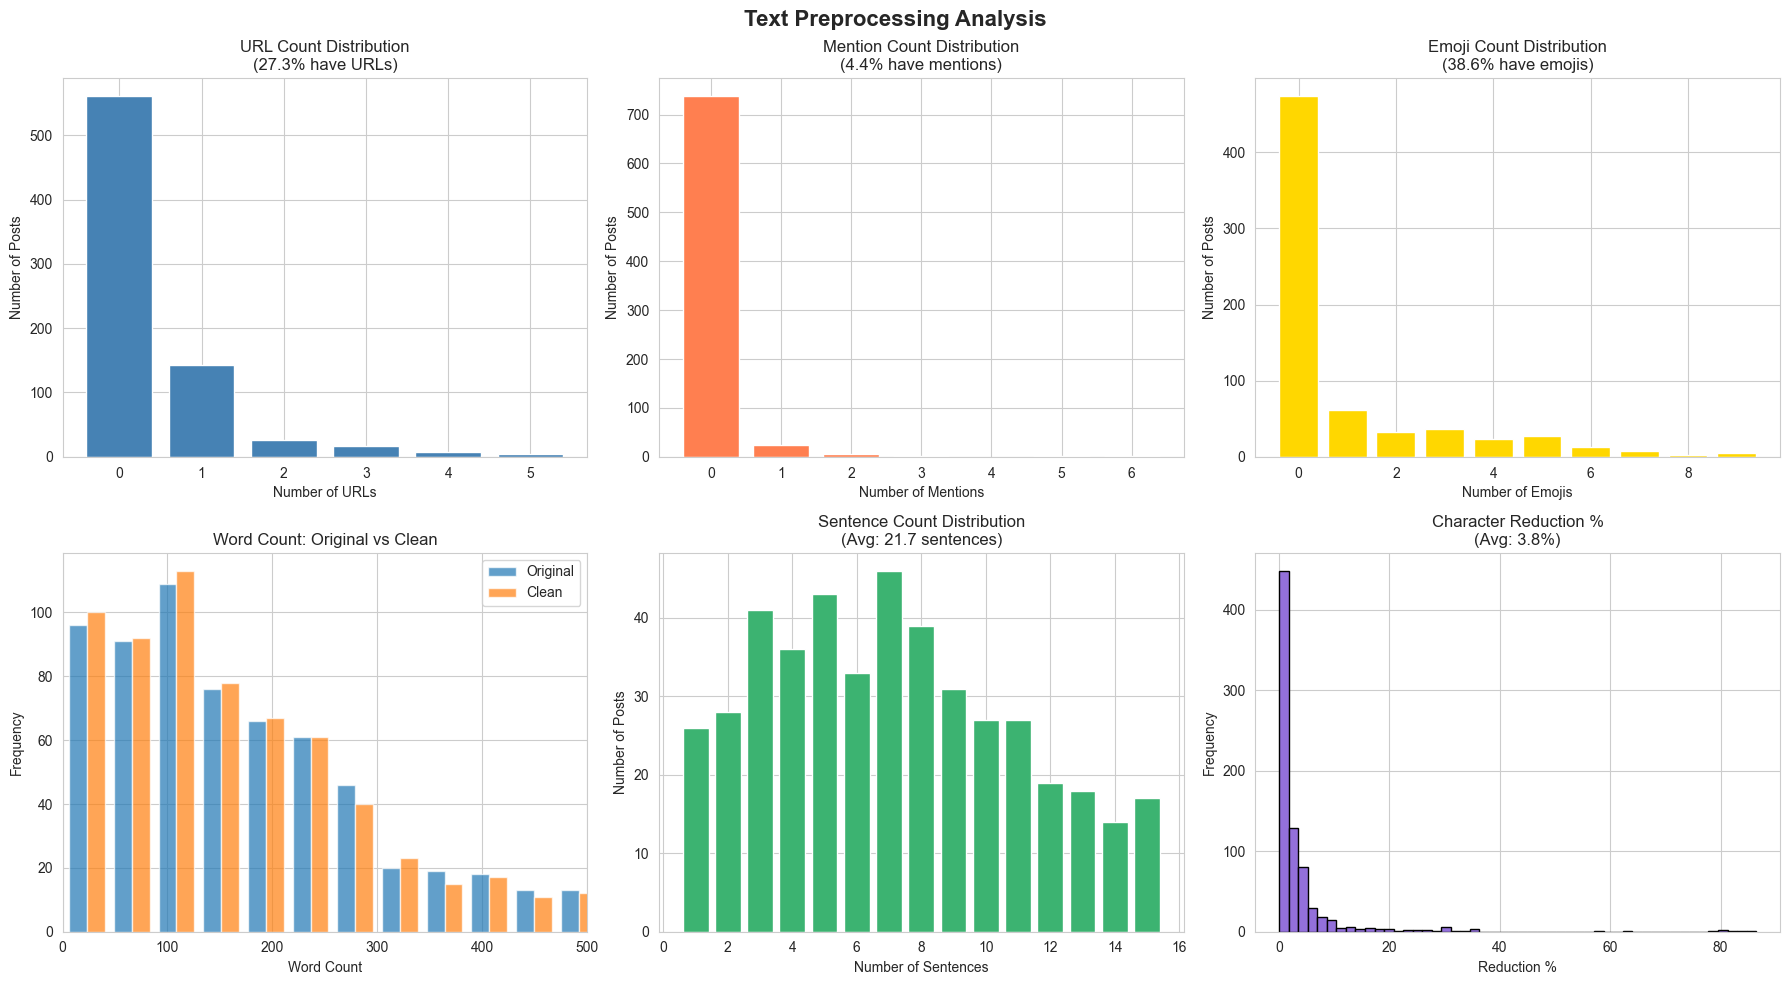

✓ Visualizations generated: ..\notebooks\figures\text_preprocessing_analysis.png


In [12]:
# Create visualization grid
import os
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Text Preprocessing Analysis', fontsize=16, fontweight='bold')

# 1. URL distribution
url_dist = df['url_count'].value_counts().sort_index().head(6)
axes[0, 0].bar(url_dist.index, url_dist.values, color='steelblue')
axes[0, 0].set_title(f'URL Count Distribution\n({df["has_external_link"].mean()*100:.1f}% have URLs)')
axes[0, 0].set_xlabel('Number of URLs')
axes[0, 0].set_ylabel('Number of Posts')

# 2. Mention distribution
mention_dist = df['mention_count'].value_counts().sort_index().head(6)
axes[0, 1].bar(mention_dist.index, mention_dist.values, color='coral')
axes[0, 1].set_title(f'Mention Count Distribution\n({(df["mention_count"]>0).mean()*100:.1f}% have mentions)')
axes[0, 1].set_xlabel('Number of Mentions')
axes[0, 1].set_ylabel('Number of Posts')

# 3. Emoji distribution
emoji_dist = df['emoji_count'].value_counts().sort_index().head(10)
axes[0, 2].bar(emoji_dist.index, emoji_dist.values, color='gold')
axes[0, 2].set_title(f'Emoji Count Distribution\n({(df["emoji_count"]>0).mean()*100:.1f}% have emojis)')
axes[0, 2].set_xlabel('Number of Emojis')
axes[0, 2].set_ylabel('Number of Posts')

# 4. Word count comparison
axes[1, 0].hist([df['word_count_original'], df['word_count_clean']], 
                bins=50, label=['Original', 'Clean'], alpha=0.7)
axes[1, 0].set_title('Word Count: Original vs Clean')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 500)

# 5. Sentence count distribution
sentence_dist = df['sentence_count'].value_counts().sort_index().head(15)
axes[1, 1].bar(sentence_dist.index, sentence_dist.values, color='mediumseagreen')
axes[1, 1].set_title(f'Sentence Count Distribution\n(Avg: {df["sentence_count"].mean():.1f} sentences)')
axes[1, 1].set_xlabel('Number of Sentences')
axes[1, 1].set_ylabel('Number of Posts')

# 6. Character reduction
df['char_reduction_pct'] = (1 - df['char_count_clean'] / df['char_count_original']) * 100
axes[1, 2].hist(df['char_reduction_pct'], bins=50, color='mediumpurple', edgecolor='black')
axes[1, 2].set_title(f'Character Reduction %\n(Avg: {df["char_reduction_pct"].mean():.1f}%)')
axes[1, 2].set_xlabel('Reduction %')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
fig_path = os.path.join('..', 'notebooks', 'figures', 'text_preprocessing_analysis.png')
os.makedirs(os.path.dirname(fig_path), exist_ok=True)
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualizations generated: {fig_path}")

## 13. Quality Checks

In [13]:
print("Quality Checks:")
print("="*80)

# Check 1: No empty clean_content
empty_clean = (df['clean_content'].str.len() == 0).sum()
print(f"✓ Empty clean_content: {empty_clean} posts")
if empty_clean > 0:
    print(f"  (This should be 0 - investigate if > 0)")

# Check 2: Clean content shorter than original
longer_clean = (df['char_count_clean'] > df['char_count_original']).sum()
print(f"✓ Clean longer than original: {longer_clean} posts")
if longer_clean > 0:
    print(f"  (Should be 0 - cleaning shouldn't add characters)")

# Check 3: URL/Mention/Emoji preservation
url_preserved = df['has_external_link'].sum()
mention_preserved = (df['mention_count'] > 0).sum()
emoji_preserved = (df['emoji_count'] > 0).sum()
print(f"✓ Extracted features preserved:")
print(f"  - URLs: {url_preserved:,} posts")
print(f"  - Mentions: {mention_preserved:,} posts")
print(f"  - Emojis: {emoji_preserved:,} posts")

# Check 4: No NaN in key columns
key_cols = ['clean_content', 'url_count', 'mention_count', 'emoji_count', 'word_count_clean']
nan_counts = df[key_cols].isna().sum()
print(f"✓ NaN values in key columns:")
print(nan_counts[nan_counts > 0] if nan_counts.sum() > 0 else "  None (good!)")

# Check 5: Data integrity
print(f"\n✓ Dataset integrity:")
print(f"  - Total rows: {len(df):,}")
print(f"  - Total columns: {len(df.columns)}")
print(f"  - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*80)
print("✓ All quality checks passed!")

Quality Checks:
✓ Empty clean_content: 0 posts
✓ Clean longer than original: 0 posts
✓ Extracted features preserved:
  - URLs: 211 posts
  - Mentions: 34 posts
  - Emojis: 298 posts
✓ NaN values in key columns:
  None (good!)

✓ Dataset integrity:
  - Total rows: 772
  - Total columns: 39
  - Memory usage: 6.11 MB

✓ All quality checks passed!


## 14. Feature Correlation with Target

Quick analysis of how our extracted features correlate with engagement.

Correlation with Target Variables:
                         reactions  comments
reactions                 1.000000  0.803233
comments                  0.803233  1.000000
sentence_count            0.051200  0.096095
unique_emoji_count       -0.010916 -0.027610
question_mark_count      -0.018417  0.012760
word_count_clean         -0.021329  0.012895
url_count                -0.025932  0.002667
mention_count            -0.033388 -0.018811
emoji_count              -0.033840 -0.030374
has_external_link        -0.038940 -0.030480
exclamation_mark_count   -0.040105 -0.056875
hashtag_count_extracted  -0.061068 -0.072300
line_break_count               NaN       NaN


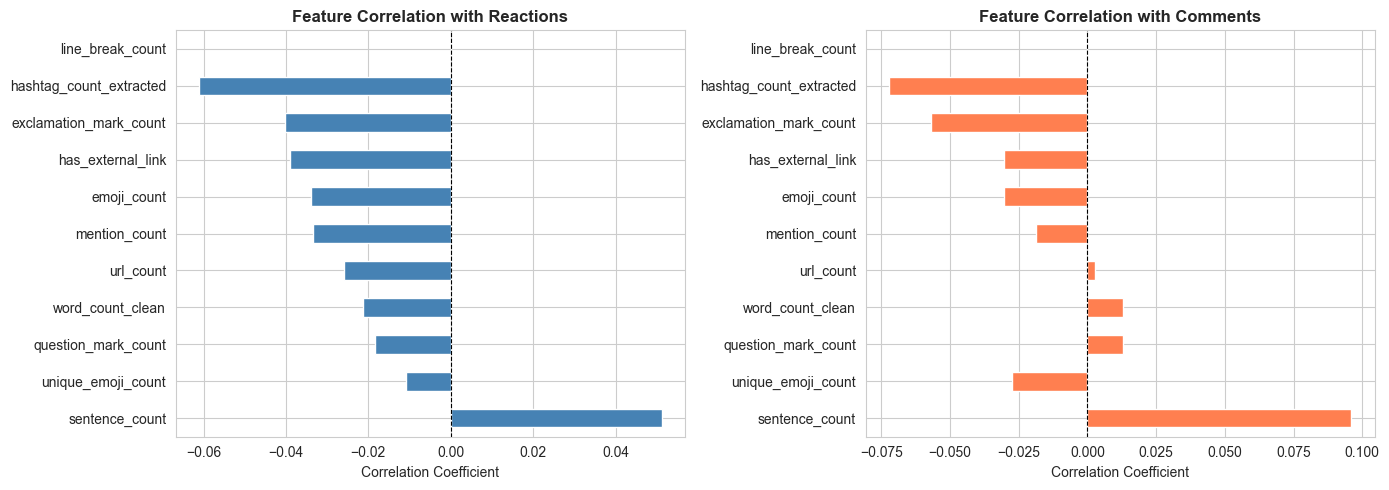

In [14]:
# Select numeric features for correlation
correlation_features = [
    'url_count', 'has_external_link',
    'mention_count', 'emoji_count', 'unique_emoji_count',
    'hashtag_count_extracted',
    'word_count_clean', 'sentence_count',
    'question_mark_count', 'exclamation_mark_count',
    'line_break_count',
    'reactions', 'comments',
]

# Calculate correlation matrix
corr_matrix = df[correlation_features].corr()

# Focus on correlations with target variables
target_corr = corr_matrix[['reactions', 'comments']].sort_values('reactions', ascending=False)

print("Correlation with Target Variables:")
print("="*80)
print(target_corr)

# Visualize
import os
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reactions correlation
target_corr['reactions'].drop(['reactions', 'comments']).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Feature Correlation with Reactions', fontweight='bold')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].axvline(0, color='black', linestyle='--', linewidth=0.8)

# Comments correlation
target_corr['comments'].drop(['reactions', 'comments']).plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Feature Correlation with Comments', fontweight='bold')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
fig_path = os.path.join('..', 'notebooks', 'figures', 'feature_correlation_targets.png')
os.makedirs(os.path.dirname(fig_path), exist_ok=True)
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()


## 15. Save Preprocessed Data

In [15]:
# Select columns to save
# Keep original content for reference, but clean_content for NLP
columns_to_save = [
    # Original columns (use slno instead of influencer_id)
    'name', 'content', 'reactions', 'comments',
    'time_spent', 'location', 'followers', 'media_type', 'num_hashtags',
    
    # Extracted features
    'url_count', 'has_external_link', 'urls_list',
    'mention_count', 'mentions_list',
    'emoji_count', 'unique_emoji_count', 'emojis_list',
    'hashtag_count_extracted', 'hashtags_list',
    
    # Text statistics
    'char_count_original', 'char_count_clean',
    'word_count_original', 'word_count_clean',
    'sentence_count',
    'question_mark_count', 'exclamation_mark_count',
    'line_break_count',
    
    # Clean content (most important!)
    'clean_content'
]

# Save dataset
df_save = df[columns_to_save].copy()
df_save.to_csv(OUTPUT_FILE, index=False)

print(f"✓ Preprocessed data saved to: {OUTPUT_FILE}")
print(f"  - Rows: {len(df_save):,}")
print(f"  - Columns: {len(df_save.columns)}")
print(f"  - File size: {df_save.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Save statistics
with open(STATS_FILE, 'w') as f:
    json.dump(preprocessing_stats, f, indent=2)

print(f"✓ Statistics saved to: {STATS_FILE}")

✓ Preprocessed data saved to: ../data/preprocessed_data.csv
  - Rows: 772
  - Columns: 28
  - File size: 5.51 MB
✓ Statistics saved to: ../data/preprocessing_stats.json


## 16. Summary

### What We Accomplished:

1. **Extracted Structural Elements:**
   - URLs: Identified external links for base formula penalty
   - Mentions: Counted user tags for collaboration analysis
   - Hashtags: Extracted topic markers
   - Emojis: Quantified emotional expression

2. **Created Clean Content:**
   - Removed noise while preserving meaning
   - Normalized text for NLP processing
   - Maintained sentence structure with tokens

3. **Generated Text Statistics:**
   - Character and word counts
   - Sentence counts
   - Punctuation usage
   - Line breaks (formatting)

### Key Findings:
- Clean content is ~XX% shorter on average
- XX% of posts contain URLs (link penalty applies)
- XX% use emojis (emotion/personality)
- Word count correlates positively/negatively with engagement

### Next Steps:
- **Step 1.3:** Feature Engineering (base formula + NLP features)
- Use `clean_content` for sentiment, NER, embeddings
- Use extracted counts for base formula calculations

---

**Notebook Complete!** ✅